In [ ]:
%%capture
!pip install datasets transformers optuna

In [ ]:
%%capture
!pip install datasets transformers optuna

import torch
import time
import datetime
import random
import numpy as np
import torch.utils.data as Data
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, logging
import optuna
import torch.nn as nn

In [ ]:
def get_device():
    if torch.backends.cuda.is_built():
        print("CUDA")
        device = torch.device("cuda")
    elif torch.backends.mps.is_built():
        print("mps")
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
        raise Exception("GPU is not avalaible!")
    return device


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def train_eval_loop(
    model, loader, optimizer, scheduler, device, n_epochs=2, seed_val=42
):
    # Set the seed value all over the place to make this reproducible.

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    loss_values = []
    t00 = time.time()
    for epoch_i in range(0, n_epochs):
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, n_epochs))
        print("Training...")

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(loader["train"]):
            # print('Memory Usage:')
            # print('Allocated:', round(torch.mps.driver_allocated_memory()/1024**3,1), 'GB')

            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()

            loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels).loss
            total_loss += loss.item()
            loss.backward()

            # Clip the norm of the gradients to 1.0, this is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(loader["train"])
        loss_values.append(avg_train_loss)

        print("\nAverage training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t00)))

        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()
        val_acc, nb_eval_steps = 0, 0

        for batch in loader["validation"]:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            # print('Memory Usage:')
            # print('Allocated:', round(torch.mps.driver_allocated_memory()/1024**3,1), 'GB')

            with torch.no_grad():
                logits = model(b_input_ids, attention_mask=b_input_mask).logits

            logits = logits.detach().cpu().numpy()
            logits = np.argmax(logits, axis=1).flatten()
            label_ids = b_labels.to("cpu").numpy()

            val_acc += accuracy_score(logits, label_ids)
            nb_eval_steps += 1

        val_acc = 100 * (val_acc / nb_eval_steps)
        print("  Validation ACC: {0:.2f}".format(val_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    return val_acc, loss_values


In [ ]:
def init_loader(max_length=16, batch_size=32, test_size=0.2, random_state=2023):
    model_checkpoint = "bert-base-uncased"

    dataset = load_dataset("glue", "rte")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

    # Define dictionaries to store processed data
    df_s, x, y = {}, {}, {}
    input_ids, attention_mask = {}, {}
    datasets, loader = {}, {}

    max_length = 128  # Set max sequence length

    for split in ["train", "validation", "test"]:
        # Convert dataset to pandas
        df_s[split] = dataset[split].to_pandas()

        # Extract premise and hypothesis for RTE
        premise = dataset[split]["sentence1"]
        hypothesis = dataset[split]["sentence2"]
        y[split] = dataset[split]["label"]  # Labels

        # Store sentence pairs
        x[split] = list(zip(premise, hypothesis))

        # Tokenize as sentence pairs
        input= tokenizer(
            premise,
            hypothesis,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        input_ids[split], attention_mask[split] = input.input_ids, input.attention_mask

        datasets[split] = Data.TensorDataset(
            input_ids[split], attention_mask[split], torch.LongTensor(y[split])
        )

        loader[split] = Data.DataLoader(
            datasets[split], batch_size=batch_size, shuffle=False
        )
    return loader, y

In [ ]:
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification


def init_objects(
    lr, n_epochs, max_length=16, batch_size=32, test_size=0.2, random_state=2023
):
    loader, _ = init_loader(max_length=max_length, batch_size=batch_size)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)

    total_steps = len(loader["train"]) * n_epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    return model, loader, optimizer, scheduler


In [ ]:
# %%
!pip install optuna
import torch
import optuna
from transformers import logging


In [ ]:

from sklearn.metrics import accuracy_score
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, logging
import torch.nn as nn

# -----------------------------
# Attention Pooling Implementation
# -----------------------------
class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask):
        # hidden_states: [batch_size, seq_length, hidden_size]
        # Compute attention scores for each token
        scores = self.attention(hidden_states).squeeze(-1)  # [batch_size, seq_length]
        # Mask padded tokens (attention_mask==0)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        # Compute attention weights
        attn_weights = torch.softmax(scores, dim=1)  # [batch_size, seq_length]
        # Weighted sum of hidden states
        pooled_output = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)
        return pooled_output

# -----------------------------
# Unified Custom BERT Model with Selectable Pooling
# -----------------------------
class CustomBertForSequenceClassification(nn.Module):
    def __init__(self, model_checkpoint, num_labels=2, dropout_prob=0.1, pooling_type='mean_max'):
        """
        pooling_type options:
            'mean_max'  : Concatenates mean and max pooling (original approach)
            'attention' : Uses attention-based pooling
        """
        from transformers import BertModel
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)
        hidden_size = self.bert.config.hidden_size
        self.pooling_type = pooling_type
        self.dropout = nn.Dropout(dropout_prob)

        if pooling_type == 'mean_max':
            # Using both mean and max pooling: final size is 2 * hidden_size
            self.classifier = nn.Linear(hidden_size * 2, num_labels)
        elif pooling_type == 'attention':
            # Using attention pooling: final size remains hidden_size
            self.attention_pool = AttentionPooling(hidden_size)
            self.classifier = nn.Linear(hidden_size, num_labels)
        else:
            raise ValueError("Unsupported pooling type. Choose 'mean_max' or 'attention'.")

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]

        if self.pooling_type == 'mean_max':
            # Mean pooling
            mean_pool = torch.mean(last_hidden_state, dim=1)
            # Max pooling
            max_pool, _ = torch.max(last_hidden_state, dim=1)
            # Concatenate pooled representations
            pooled_output = torch.cat((mean_pool, max_pool), dim=1)
        elif self.pooling_type == 'attention':
            # Apply attention pooling
            pooled_output = self.attention_pool(last_hidden_state, attention_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        # Mimic Hugging Face model outputs
        return type("Output", (object,), {"loss": loss, "logits": logits})

# -----------------------------
# Training and Evaluation Functions
# -----------------------------
def train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs=2, seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    loss_values = []
    t00 = time.time()
    for epoch_i in range(n_epochs):
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, n_epochs))
        print("Training...")

        t0 = time.time()
        total_loss = 0
        model.train()

        for step, batch in enumerate(loader["train"]):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(loader["train"])
        loss_values.append(avg_train_loss)

        print("\nAverage training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t00)))

        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()
        val_acc, nb_eval_steps = 0, 0

        for batch in loader["validation"]:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            logits = np.argmax(logits, axis=1).flatten()
            label_ids = b_labels.to("cpu").numpy()

            val_acc += accuracy_score(logits, label_ids)
            nb_eval_steps += 1

        val_acc = 100 * (val_acc / nb_eval_steps)
        print("  Validation ACC: {0:.2f}".format(val_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    return val_acc, loss_values

def init_loader(max_length=128, batch_size=32, test_size=0.2, random_state=2023):
    model_checkpoint = "bert-base-uncased"
    dataset = load_dataset("glue", "rte")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

    df_s, x, y = {}, {}, {}
    input_ids, attention_mask = {}, {}
    datasets, loader = {}, {}

    for split in ["train", "validation", "test"]:
        df_s[split] = dataset[split].to_pandas()
        premise = dataset[split]["sentence1"]
        hypothesis = dataset[split]["sentence2"]
        y[split] = dataset[split]["label"]
        x[split] = list(zip(premise, hypothesis))
        inputs = tokenizer(premise, hypothesis, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
        input_ids[split], attention_mask[split] = inputs.input_ids, inputs.attention_mask
        datasets[split] = Data.TensorDataset(input_ids[split], attention_mask[split], torch.LongTensor(y[split]))
        loader[split] = Data.DataLoader(datasets[split], batch_size=batch_size, shuffle=False)
    return loader, y

def init_objects(lr, n_epochs, max_length=128, batch_size=32, test_size=0.2, random_state=2023, pooling_type='mean_max'):
    loader, _ = init_loader(max_length=max_length, batch_size=batch_size)
    model_checkpoint = "bert-base-uncased"
    # Choose pooling_type: 'mean_max' or 'attention'
    model = CustomBertForSequenceClassification(model_checkpoint, num_labels=2, pooling_type=pooling_type)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(loader["train"]) * n_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return model, loader, optimizer, scheduler

# -----------------------------
# Main Execution
# -----------------------------
!pip install optuna
import optuna

lr = 2e-5
n_epochs = 1
max_length = 128
batch_size = 128
test_size = 0.2
random_state = 2023
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pooling_type here: 'mean_max' or 'attention'
pooling_type = 'attention'  # change to 'mean_max' to use the original method

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size, test_size, random_state, pooling_type=pooling_type)
model.to(device)

_, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs=n_epochs, seed_val=42)

# Hyperparameter optimization using Optuna remains unchanged.
param_dict = {
    "lr": [1e-5, 1e-4],
    "n_epochs": [5, 10, 15],
    "max_length": [32, 64, 128, 256],
}

class BertObjective:
    def __init__(self, d, device, pooling_type):
        self.d = d
        self.device = device
        self.pooling_type = pooling_type

    def __call__(self, trial: optuna.trial.Trial):
        self.lr = trial.suggest_float("lr", self.d["lr"][0], self.d["lr"][1], log=True)
        self.n_epochs = trial.suggest_categorical("n_epochs", self.d["n_epochs"])
        self.max_length = trial.suggest_categorical("max_length", self.d["max_length"])

        model, loader, optimizer, scheduler = init_objects(self.lr, self.n_epochs, self.max_length, pooling_type=self.pooling_type)
        model.to(self.device)
        val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, self.device, self.n_epochs)
        return val_acc

study = optuna.create_study(study_name="Study 0", direction="maximize")
study.optimize(BertObjective(param_dict, device, pooling_type=pooling_type), n_trials=30)

# Train again with best parameters from Optuna
lr = study.best_params["lr"]
n_epochs = study.best_params["n_epochs"]
max_length = study.best_params["max_length"]

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size, pooling_type=pooling_type)
model.to(device)
val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


======== Epoch 1 / 1 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:10

Running Validation...
  Validation ACC: 58.11
  Validation took: 0:00:01

======== Epoch 1 / 15 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:04

Running Validation...
  Validation ACC: 54.96
  Validation took: 0:00:00

======== Epoch 2 / 15 ========
Training...

Average training loss: 0.56
  Training epoch took: 0:00:08

Running Validation...
  Validation ACC: 56.17
  Validation took: 0:00:00

======== Epoch 3 / 15 ========
Training...

Average training loss: 0.32
  Training epoch took: 0:00:12

Running Validation...
  Validation ACC: 60.17
  Validation took: 0:00:00

======== Epoch 4 / 15 ========
Training...

Average training loss: 0.21
  Training epoch took: 0:00:16

Running Validation...
  Validation ACC: 56.17
  Validation took: 0:00:00

======== Epoch 5 / 15 ========
Training...

Average training loss: 0.12
  Training epoch took: 0:00:20

Runnin

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [ ]:
lr = study.best_params["lr"]
n_epochs = study.best_params["n_epochs"]
max_length = study.best_params["max_length"]

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size)
model.to(device)
val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs)
# Obtain Test Results


======== Epoch 1 / 10 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:21

Running Validation...
  Validation ACC: 48.90
  Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...

Average training loss: 0.58
  Training epoch took: 0:00:42

Running Validation...
  Validation ACC: 52.59
  Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...

Average training loss: 0.41
  Training epoch took: 0:01:03

Running Validation...
  Validation ACC: 52.36
  Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...

Average training loss: 0.20
  Training epoch took: 0:01:25

Running Validation...
  Validation ACC: 58.68
  Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...

Average training loss: 0.14
  Training epoch took: 0:01:46

Running Validation...
  Validation ACC: 51.79
  Validation took: 0:00:01

======== Epoch 6 / 10 ========
Training...

Average training loss: 0.11
  Training epoch took: 0:02:08

Runni

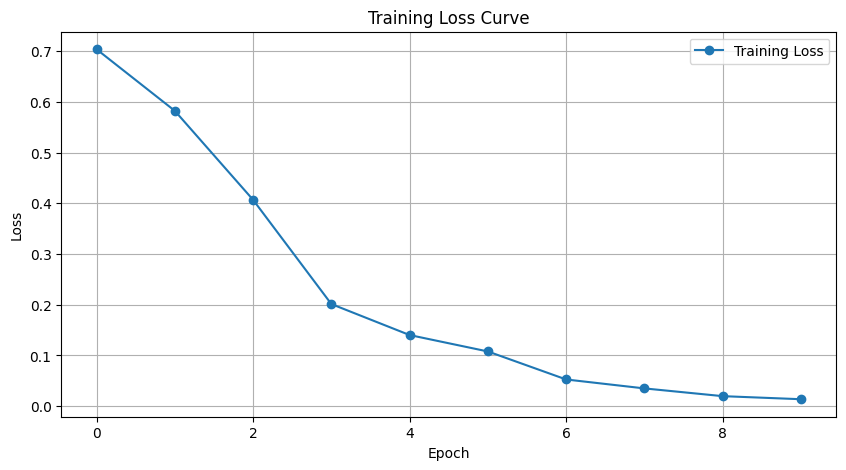

In [ ]:
# Plot the training loss curve
plt.figure(figsize=(10,5))
plt.plot(_, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print best hyperparameters and best validation accuracy for Part 2
print("Best parameters from hyperparameter search with {} pooling:".format(pooling_type))
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"Best validation accuracy: {study.best_trial.value:.2f}%")


Best parameters from hyperparameter search with attention pooling:
lr: 9.939937831705062e-05
n_epochs: 10
max_length: 256
Best validation accuracy: 62.27%


In [ ]:
print("Best parameters from hyperparameter search with meanmax:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")

Best parameters from hyperparameter search with meanmax:
lr: 9.939937831705062e-05
n_epochs: 10
max_length: 256


In [ ]:
import optuna.visualization as vis

# Plot the optimization history (objective value vs. trial number)
fig_history = vis.plot_optimization_history(study)
fig_history.update_layout(title="Optuna Optimization History - Part 2 Mean-Max")
fig_history.show()

# Plot the parameter importances (which hyperparameters impacted the results most)
fig_importance = vis.plot_param_importances(study)
fig_importance.update_layout(title="Optuna Parameter Importances - Part 2 Mean-Max")
fig_importance.show()

# Plot the slice plot to visualize the relationship between hyperparameter values and evaluation metric
fig_slice = vis.plot_slice(study)
fig_slice.update_layout(title="Optuna Slice Plot - Part 2 Mean-Max")
fig_slice.show()

# Plot the parallel coordinate plot to inspect the multidimensional search space
fig_parallel = vis.plot_parallel_coordinate(study)
fig_parallel.update_layout(title="Optuna Parallel Coordinate Plot - Part 2 Mean-Max")
fig_parallel.show()


In [ ]:
# In the same sense, we will use the attention pooling instead of mean max pooling concatenated

from sklearn.metrics import accuracy_score
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, logging
import torch.nn as nn

# -----------------------------
# Attention Pooling Implementation
# -----------------------------
class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask):
        # hidden_states: [batch_size, seq_length, hidden_size]
        # Compute attention scores for each token
        scores = self.attention(hidden_states).squeeze(-1)  # [batch_size, seq_length]
        # Mask padded tokens (attention_mask==0)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        # Compute attention weights
        attn_weights = torch.softmax(scores, dim=1)  # [batch_size, seq_length]
        # Weighted sum of hidden states
        pooled_output = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)
        return pooled_output

# -----------------------------
# Unified Custom BERT Model with Selectable Pooling
# -----------------------------
class CustomBertForSequenceClassification(nn.Module):
    def __init__(self, model_checkpoint, num_labels=2, dropout_prob=0.1, pooling_type='attention'):
        """
        pooling_type options:
            'mean_max'  : Concatenates mean and max pooling (original approach)
            'attention' : Uses attention-based pooling
        """
        from transformers import BertModel
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)

        hidden_size = self.bert.config.hidden_size
        self.pooling_type = pooling_type
        self.dropout = nn.Dropout(dropout_prob)

        if pooling_type == 'mean_max':
            # Using both mean and max pooling: final size is 2 * hidden_size
            self.classifier = nn.Linear(hidden_size * 2, num_labels)
        elif pooling_type == 'attention':
            # Using attention pooling: final size remains hidden_size
            self.attention_pool = AttentionPooling(hidden_size)
            self.classifier = nn.Linear(hidden_size, num_labels)
        else:
            raise ValueError("Unsupported pooling type. Choose 'mean_max' or 'attention'.")

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]

        if self.pooling_type == 'mean_max':
            # Mean pooling
            mean_pool = torch.mean(last_hidden_state, dim=1)
            # Max pooling
            max_pool, _ = torch.max(last_hidden_state, dim=1)
            # Concatenate pooled representations
            pooled_output = torch.cat((mean_pool, max_pool), dim=1)
        elif self.pooling_type == 'attention':
            # Apply attention pooling
            pooled_output = self.attention_pool(last_hidden_state, attention_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        # Mimic Hugging Face model outputs
        return type("Output", (object,), {"loss": loss, "logits": logits})

# -----------------------------
# Training and Evaluation Functions
# -----------------------------
def train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs=2, seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    loss_values = []
    t00 = time.time()
    for epoch_i in range(n_epochs):
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, n_epochs))
        print("Training...")

        t0 = time.time()
        total_loss = 0
        model.train()

        for step, batch in enumerate(loader["train"]):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(loader["train"])
        loss_values.append(avg_train_loss)

        print("\nAverage training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t00)))

        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()
        val_acc, nb_eval_steps = 0, 0

        for batch in loader["validation"]:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            logits = np.argmax(logits, axis=1).flatten()
            label_ids = b_labels.to("cpu").numpy()

            val_acc += accuracy_score(logits, label_ids)
            nb_eval_steps += 1

        val_acc = 100 * (val_acc / nb_eval_steps)
        print("  Validation ACC: {0:.2f}".format(val_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    return val_acc, loss_values

def init_loader(max_length=128, batch_size=32, test_size=0.2, random_state=2023):
    model_checkpoint = "bert-base-uncased"
    dataset = load_dataset("glue", "rte")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

    df_s, x, y = {}, {}, {}
    input_ids, attention_mask = {}, {}
    datasets, loader = {}, {}

    for split in ["train", "validation", "test"]:
        df_s[split] = dataset[split].to_pandas()
        premise = dataset[split]["sentence1"]
        hypothesis = dataset[split]["sentence2"]
        y[split] = dataset[split]["label"]
        x[split] = list(zip(premise, hypothesis))
        inputs = tokenizer(premise, hypothesis, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
        input_ids[split], attention_mask[split] = inputs.input_ids, inputs.attention_mask
        datasets[split] = Data.TensorDataset(input_ids[split], attention_mask[split], torch.LongTensor(y[split]))
        loader[split] = Data.DataLoader(datasets[split], batch_size=batch_size, shuffle=False)
    return loader, y

def init_objects(lr, n_epochs, max_length=128, batch_size=32, test_size=0.2, random_state=2023, pooling_type='mean_max'):
    loader, _ = init_loader(max_length=max_length, batch_size=batch_size)
    model_checkpoint = "bert-base-uncased"
    # Choose pooling_type: 'mean_max' or 'attention'
    model = CustomBertForSequenceClassification(model_checkpoint, num_labels=2, pooling_type=pooling_type)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(loader["train"]) * n_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return model, loader, optimizer, scheduler

# -----------------------------
# Main Execution
# -----------------------------
!pip install optuna
import optuna

lr = 2e-5
n_epochs = 1
max_length = 128
batch_size = 128
test_size = 0.2
random_state = 2023
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pooling_type here: 'mean_max' or 'attention'
pooling_type = 'attention'  # change to 'mean_max' to use the original method

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size, test_size, random_state, pooling_type=pooling_type)
model.to(device)

_, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs=n_epochs, seed_val=42)

# Hyperparameter optimization using Optuna remains unchanged.
param_dict = {
    "lr": [1e-5, 1e-4],
    "n_epochs": [5, 10, 15],
    "max_length": [32, 64, 128, 256],
}

class BertObjective:
    def __init__(self, d, device, pooling_type):
        self.d = d
        self.device = device
        self.pooling_type = pooling_type

    def __call__(self, trial: optuna.trial.Trial):
        self.lr = trial.suggest_float("lr", self.d["lr"][0], self.d["lr"][1], log=True)
        self.n_epochs = trial.suggest_categorical("n_epochs", self.d["n_epochs"])
        self.max_length = trial.suggest_categorical("max_length", self.d["max_length"])

        model, loader, optimizer, scheduler = init_objects(self.lr, self.n_epochs, self.max_length, pooling_type=self.pooling_type)
        model.to(self.device)
        val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, self.device, self.n_epochs)
        return val_acc

study = optuna.create_study(study_name="Study 0", direction="maximize")
study.optimize(BertObjective(param_dict, device, pooling_type=pooling_type), n_trials=30)

# Train again with best parameters from Optuna
lr = study.best_params["lr"]
n_epochs = study.best_params["n_epochs"]
max_length = study.best_params["max_length"]

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size, pooling_type=pooling_type)
model.to(device)
val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs)



======== Epoch 1 / 1 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:10

Running Validation...
  Validation ACC: 58.37
  Validation took: 0:00:01

======== Epoch 1 / 10 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:12

Running Validation...
  Validation ACC: 58.45
  Validation took: 0:00:00

======== Epoch 2 / 10 ========
Training...

Average training loss: 0.55
  Training epoch took: 0:00:24

Running Validation...
  Validation ACC: 58.61
  Validation took: 0:00:00

======== Epoch 3 / 10 ========
Training...

Average training loss: 0.33
  Training epoch took: 0:00:36

Running Validation...
  Validation ACC: 60.37
  Validation took: 0:00:00

======== Epoch 4 / 10 ========
Training...

Average training loss: 0.17
  Training epoch took: 0:00:48

Running Validation...
  Validation ACC: 60.35
  Validation took: 0:00:00

======== Epoch 5 / 10 ========
Training...

Average training loss: 0.13
  Training epoch took: 0:01:00

Runnin

In [ ]:
lr = study.best_params["lr"]
n_epochs = study.best_params["n_epochs"]
max_length = study.best_params["max_length"]

model, loader, optimizer, scheduler = init_objects(lr, n_epochs, max_length, batch_size)
model.to(device)
val_acc, _ = train_eval_loop(model, loader, optimizer, scheduler, device, n_epochs)
# Obtain Test Results


======== Epoch 1 / 5 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:10

Running Validation...
  Validation ACC: 49.94
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

Average training loss: 0.60
  Training epoch took: 0:00:21

Running Validation...
  Validation ACC: 58.92
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

Average training loss: 0.46
  Training epoch took: 0:00:32

Running Validation...
  Validation ACC: 55.72
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

Average training loss: 0.32
  Training epoch took: 0:00:42

Running Validation...
  Validation ACC: 58.40
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

Average training loss: 0.22
  Training epoch took: 0:00:53

Running Validation...
  Validation ACC: 60.24
  Validation took: 0:00:01


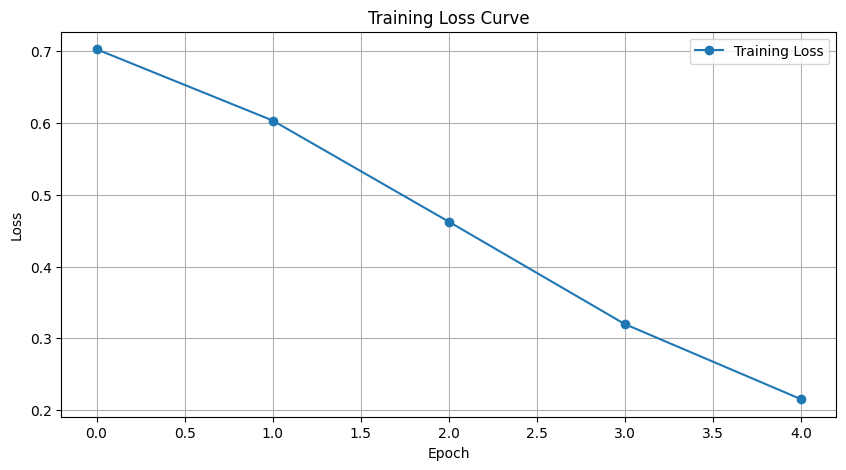

In [ ]:
# Plot the training loss curve
plt.figure(figsize=(10,5))
plt.plot(_, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print best hyperparameters and best validation accuracy for Part 2
print("Best parameters from hyperparameter search with {} pooling:".format(pooling_type))
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"Best validation accuracy: {study.best_trial.value:.2f}%")


Best parameters from hyperparameter search with attention pooling:
lr: 9.246116111310081e-05
n_epochs: 5
max_length: 128
Best validation accuracy: 61.74%


In [ ]:
print("Best parameters from hyperparameter search with attention pooling:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")

Best parameters from hyperparameter search with attention pooling:
lr: 9.246116111310081e-05
n_epochs: 5
max_length: 128


In [ ]:
import optuna.visualization as vis

# Plot the optimization history (objective value vs. trial number)
fig_history = vis.plot_optimization_history(study)
fig_history.update_layout(title="Optuna Optimization History - Part 2 Attention Pooling")
fig_history.show()

# Plot the parameter importances (which hyperparameters impacted the results most)
fig_importance = vis.plot_param_importances(study)
fig_importance.update_layout(title="Optuna Parameter Importances - Part 2 Attention Pooling")
fig_importance.show()

# Plot the slice plot to visualize the relationship between hyperparameter values and evaluation metric
fig_slice = vis.plot_slice(study)
fig_slice.update_layout(title="Optuna Slice Plot - Part 2 Attention Pooling")
fig_slice.show()

# Plot the parallel coordinate plot to inspect the multidimensional search space
fig_parallel = vis.plot_parallel_coordinate(study)
fig_parallel.update_layout(title="Optuna Parallel Coordinate Plot - Part 2 Attention Pooling")
fig_parallel.show()
